In [1]:
import uproot as up
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import joblib

import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Check access to GPU
torch.cuda.is_available()

# Assign the name to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# Load the eval ROOT file

#700_200_mc20e.root
#700_250_mc20e.root
#700_350_mc20e.root
#700_400_mc20e.root
#700_450_mc20e.root
#user.rjoshi.38019065._000001.output.root
name = "user.rjoshi.38019065._000001.output"
#file_path = "/data/dajiang/2HDM/ML/samples/signal/Test_High/{}.root".format(name) # signal
file_path = "/data/dajiang/2HDM/ML/samples/ttbar/validation/{}.root".format(name) # ttbar
tree = up.open(file_path)["reco"]
arrays = tree.arrays(library = "np")
temp_df = pd.DataFrame(arrays)
df = temp_df[(temp_df['nBjets_NOSYS'] > 1) & (temp_df['nBjets_NOSYS'] + temp_df['nLjets_NOSYS'] > 3)] # preselection cuts

KeyboardInterrupt: 

In [5]:
# Define vectorized deltaR function
def deltaR(eta1, phi1, eta2, phi2):
    d_eta = eta1 - eta2
    d_phi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(d_eta**2 + d_phi**2)

# Define function to calculate delta R between two objects
def calculate_deltaR(df, object1_prefix, object2_prefix):
    # Create new column name
    col_name = f'deltaR_{object1_prefix}_{object2_prefix}'
    
    # Select the appropriate columns for eta and phi
    eta1 = df.get(f'{object1_prefix}_eta_NOSYS', df.get(f'{object1_prefix}_eta_fitted_NOSYS', np.nan))
    phi1 = df.get(f'{object1_prefix}_phi_NOSYS', df.get(f'{object1_prefix}_phi_fitted_NOSYS', np.nan))
    eta2 = df.get(f'{object2_prefix}_eta_NOSYS', df.get(f'{object2_prefix}_eta_fitted_NOSYS', np.nan))
    phi2 = df.get(f'{object2_prefix}_phi_NOSYS', df.get(f'{object2_prefix}_phi_fitted_NOSYS', np.nan))
    
    # Handle invalid entries (set delta R to NaN for invalid inputs)
    mask = (eta1 == -999) | (eta2 == -999) | (phi1 == -999) | (phi2 == -999)
    delta_r = deltaR(eta1, phi1, eta2, phi2)
    delta_r[mask] = np.nan
    
    # Assign the computed delta R to the new column
    df[col_name] = delta_r

# Define combinations for sig_df and ttbar_df: 78 total
combinations = [
    ('A', 'Hp'), ('A', 'top'), ('A', 'WfromTop'), ('A', 'WfromH'), ('A', 'Wb_nonTop'),
    ('Hp', 'top'), ('Hp', 'WfromTop'), ('Hp', 'WfromH'), ('Hp', 'Wb_nonTop'),
    ('top', 'WfromTop'), ('top', 'WfromH'), ('top', 'Wb_nonTop'),
    ('WfromTop', 'WfromH'), ('WfromTop', 'Wb_nonTop'),
    ('WfromH', 'Wb_nonTop'),
    ('bjet1', 'bjet2'), ('ljet1', 'ljet2'), ('bjet1', 'ljet1'), ('bjet1', 'ljet2'),
    ('bjet2', 'ljet1'), ('bjet2', 'ljet2'), ('bjet1', 'ljet3'), ('bjet1', 'ljet4'),
    ('bjet2', 'ljet3'), ('bjet2', 'ljet4'), ('ljet1', 'ljet3'), ('ljet1', 'ljet4'),
    ('ljet2', 'ljet3'), ('ljet2', 'ljet4'), ('ljet3', 'ljet4'),
    ('bjet1', 'lepton'), ('bjet2', 'lepton'), ('ljet1', 'lepton'),
    ('ljet2', 'lepton'), ('ljet3', 'lepton'), ('ljet4', 'lepton'),
    ('A', 'bjet1'), ('A', 'bjet2'), ('A', 'ljet1'), ('A', 'ljet2'),
    ('A', 'ljet3'), ('A', 'ljet4'), ('A', 'lepton'),
    ('top', 'bjet1'), ('top', 'bjet2'), ('top', 'ljet1'), ('top', 'ljet2'),
    ('top', 'ljet3'), ('top', 'ljet4'), ('top', 'lepton'),
    ('WfromTop', 'bjet1'), ('WfromTop', 'bjet2'), ('WfromTop', 'ljet1'), ('WfromTop', 'ljet2'),
    ('WfromTop', 'ljet3'), ('WfromTop', 'ljet4'),('WfromTop', 'lepton'), 
    ('Wb_nonTop', 'bjet1'), ('Wb_nonTop', 'bjet2'), ('Wb_nonTop', 'ljet1'), ('Wb_nonTop', 'ljet2'),
    ('Wb_nonTop', 'ljet3'), ('Wb_nonTop', 'ljet4'), ('Wb_nonTop', 'lepton'),
    ('Hp', 'bjet1'), ('Hp', 'bjet2'), ('Hp', 'ljet1'), ('Hp', 'ljet2'),
    ('Hp', 'ljet3'), ('Hp', 'ljet4'), ('Hp', 'lepton'),
    ('WfromH', 'bjet1'), ('WfromH', 'bjet2'), ('WfromH', 'ljet1'), ('WfromH', 'ljet2'),
    ('WfromH', 'ljet3'), ('WfromH', 'ljet4'), ('WfromH', 'lepton'),
]

# Calculate delta Rs
for comb in tqdm(combinations):
    calculate_deltaR(df, comb[0], comb[1])

100%|██████████| 78/78 [00:00<00:00, 412.12it/s]


In [6]:
# Create a Model Class that inherits nn.Module
class Model(nn.Module):
    
    # Build the model architecture
    def __init__(self, in_features=20, h1=32, h2=32, out_features=1, dropout_rate=0.2):
        super().__init__() # Instantiate our nn.Module
        self.fc1 = nn.Linear(in_features, h1) 
        self.norm1 = nn.LayerNorm(h1)
        self.fc2 = nn.Linear(h1, h2)
        self.norm2 = nn.LayerNorm(h2)
        self.out = nn.Linear(h2,out_features)
        
        self.dropout = nn.Dropout(dropout_rate)
    
    # Build forward function
    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x))) # Rectified Linear Unit: If x <= 0: x = 0
        x = self.dropout(x)
        x = F.relu(self.norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.out(x)

        return torch.sigmoid(x)

In [7]:
# Load the model
model = Model()
model.load_state_dict(torch.load("dnn_model_high_classification.pth"))
model.to(device)

Model(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [8]:
features = ['MET_phi_NOSYS',
 'Hp_mass_fitted_NOSYS',
 'deltaR_Hp_Wb_nonTop',
 'deltaR_bjet1_ljet1',
 'deltaR_WfromH_bjet1',
 'WfromH_mass_fitted_NOSYS',
 'deltaR_top_WfromH',
 'ljet2_pt_NOSYS',
 'Wb_nonTop_pt_fitted_NOSYS',
 'deltaR_top_Wb_nonTop',
 'WfromTop_pt_fitted_NOSYS',
 'deltaR_bjet1_bjet2',
 'top_mass_fitted_NOSYS',
 'lepton_pt_NOSYS',
 'A_mass_fitted_NOSYS',
 'ljet1_pt_NOSYS',
 'Hp_pt_fitted_NOSYS',
 'Wb_nonTop_mass_fitted_NOSYS',
 'bjet1_pt_NOSYS',
 'WfromH_pt_fitted_NOSYS']

In [10]:
# Process test data
pipeline = joblib.load('preprocessing_pipeline_high.pkl')

df_features = df[features].copy()
df_features.replace(-999, np.nan, inplace=True)

# Scale the test data the same way as the training
df_scaled = pipeline.transform(df_features)
X_scaled = np.array(df_scaled)
X = torch.tensor(X_scaled)
X = X.to(device)

In [11]:
X.shape

torch.Size([6034, 20])

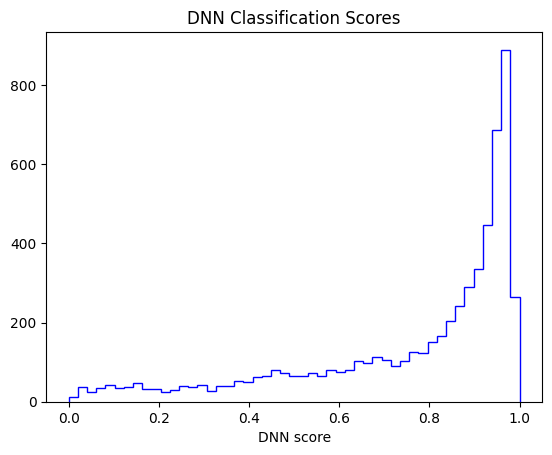

In [12]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to compute gradients during evaluation
    # Forward pass to generate predictions
    y_pred_test = model(X)

dnn_score = np.concatenate(y_pred_test.cpu().numpy())

# Plot
bin_list = np.linspace(0,1,50)
fig, ax = plt.subplots()
ax.hist(dnn_score,bins=bin_list,histtype="step",color="blue")
ax.set_xlabel("DNN score")
ax.set_title("DNN Classification Scores")
fig.show()

In [31]:
keys = ["weight_mc_NOSYS",
    "weight_jvt_effSF_NOSYS",
    "weight_btagSF_DL1dv01_FixedCutBEff_85_NOSYS"]

for key in keys:
    globals()[key] = df[key].to_numpy()

In [ ]:
weight_btagSF_DL1dv01_FixedCutBEff_85_NOSYS

In [32]:
# Save signal_predictions and background_predictions to a ROOT file

dict_type = {
    "dnn_score": "float32",
    "weight_mc_NOSYS": "float32",
    "weight_jvt_effSF_NOSYS": "float32",
    "weight_btagSF_DL1dv01_FixedCutBEff_85_NOSYS": "float32"
    }

dict_val = {
    "dnn_score": dnn_score, 
    "weight_mc_NOSYS": weight_mc_NOSYS,
    "weight_jvt_effSF_NOSYS": weight_jvt_effSF_NOSYS,
    "weight_btagSF_DL1dv01_FixedCutBEff_85_NOSYS": weight_btagSF_DL1dv01_FixedCutBEff_85_NOSYS,
    }

with up.recreate("root_files/{}_eval.root".format(name)) as f:
    tree = f.mktree("reco", dict_type)
    tree.extend(dict_val)